In [1]:
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

sns.set()

# Búsqueda de hiper-parámetros

En este notebook, exploraremos la tarea de búsqueda de hiperparámetros, un aspecto fundamental en el proceso de desarrollo de modelos de Machine Learning. Los hiper-parámetros desempeñan un 
papel crucial en la configuración y optimización de modelos, influyendo directamente en su rendimiento y capacidad de generalización. Vamos aplicar diversas técnicas y herramientas utilizadas 
para encontrar la combinación óptima de hiperparámetros que maximice el rendimiento de nuestros modelos. Desde algoritmos clásicos como la búsqueda aleatoria hasta enfoques más sofisticados como la ofrecida por el framework Optuna.

Para hacer esta búsqueda vamos a trabajar con el dataset de incumplimiento de clientes para una compañía de tarjetas de crédito. 

In [2]:
default_df = pd.read_csv("./datasets/Default.csv")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

# como siempre vamos separando nuestras variables predictoras de la variable a predecir
X = default_df.loc[:, ["balance", "income", "student"]].values
y = default_df.loc[:, "default"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train) 
X_test = sc_X.transform(X_test)

# Búsqueda de hiper-parámetros por búsqueda de grilla o aleatorio.

Empecemos con las búsquedas más sencillas. Estos métodos están implementados en scikit-learn y son útiles para explorar el espacio de hiperparámetros de manera exhaustiva o aleatoria.

La búsqueda de grilla consiste en definir una cuadrícula de valores para cada hiperparámetro que se desea optimizar, y luego evaluar exhaustivamente el rendimiento del modelo para 
cada combinación posible de valores. Aunque esta estrategia puede ser efectiva para espacios de búsqueda pequeños o cuando se tienen recursos computacionales limitados, puede volverse 
prohibitivamente costosa en espacios de búsqueda más grandes.

En este caso vamos a buscar hiper-parámetros del clasificador k-NN. Vamos a usar la distancia de Minkowski, ya que variando su coeficiente podemos calcular cualquier tipo de distancia.

Vamos a realizar la búsqueda con una validación cruzada de 3-Fold y maximizar el Score F1:

In [3]:
from sklearn.model_selection import GridSearchCV

classifier_knn = KNeighborsClassifier()

hyperparams = {"n_neighbors": np.arange(1, 30),    # Cantidad de vecinos.
               "weights": ["uniform", "distance"],  # Como se pesa los votos
               "p": np.arange(1.0, 30.0)}              # Valores para la distancia de Minkowski

# Creamos un método de busqueda por grilla:
grid = GridSearchCV(classifier_knn,
                    hyperparams,
                    refit=False,
                    cv=3,
                    scoring='f1',
                    n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29.]),
                         'weights': ['uniform', 'distance']},
             refit=False, scoring='f1')

Veamos los mejores parámetros encontrados:

In [4]:
grid.best_params_

{'n_neighbors': 10, 'p': 15.0, 'weights': 'distance'}

Evaluemos y entrenemos al mejor modelo encontrado:

In [5]:
best_knn_grid = KNeighborsClassifier(**grid.best_params_)
best_knn_grid.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=15.0, weights='distance')

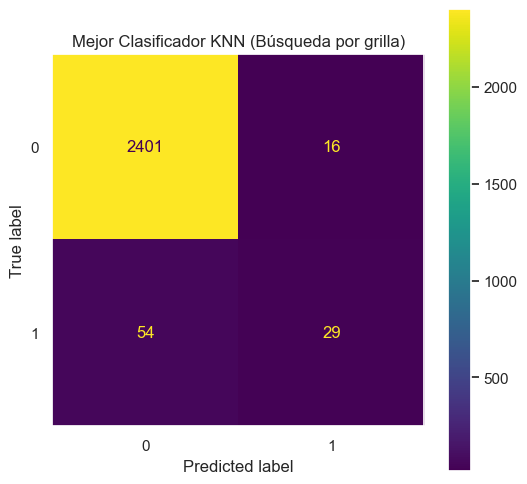

In [6]:
#Evaluamos
y_pred  = best_knn_grid.predict(X_test)

cm_best_knn_grid = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_grid,
                              display_labels=best_knn_grid.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Búsqueda por grilla)");

In [7]:
# Midamos varias métricas:
print("Mejor Clasificador KNN (Búsqueda por grilla)")
P = np.sum(cm_best_knn_grid[1, :])
N = np.sum(cm_best_knn_grid[0, :])
TP = cm_best_knn_grid[1, 1]
TN = cm_best_knn_grid[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Mejor Clasificador KNN (Búsqueda por grilla)
Sensibilidad: 0.3493975903614458
Especificidad: 0.9933802234174597
Exactitud balanceada: 0.6713889068894527
Precision: 0.6444444444444445
Recuperación: 0.3493975903614458
F1-score: 0.453125


Por otro lado, la búsqueda aleatoria selecciona aleatoriamente combinaciones de hiperparámetros para evaluar el rendimiento del modelo. Aunque esta estrategia es menos 
costosa computacionalmente que la búsqueda de grilla, puede ser menos efectiva para explorar el espacio de hiperparámetros de manera sistemática.

Usemos la búsqueda aleatoria que nos ofrece scikit-learn y aprovechemos que buscamos menos a ampliar la grilla de hiper-parámetros:

In [8]:
from sklearn.model_selection import RandomizedSearchCV

classifier_knn = KNeighborsClassifier()

hyperparams = {"n_neighbors": np.arange(1, 100),        
               "weights": ["uniform", "distance"],  
               "p": np.arange(1.0, 100.0)}              

# Creamos un método de busqueda por grilla:
grid_random = RandomizedSearchCV(classifier_knn,
                                 hyperparams,
                                 n_iter=1800, # Es el mismo número de iteraciones que el anterior pero la grilla es más grande.
                                 refit=False,
                                 cv=3,
                                 scoring='f1',
                                 n_jobs=-1)

grid_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=1800,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8...
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91.,
       92., 93., 94., 95., 96., 97., 98., 99.]),
                                        'weights': ['uniform', 'distance']},
                   refit=False, scoring='f1')

Veamos los mejores parámetros encontrados:

In [9]:
grid_random.best_params_

{'weights': 'distance', 'p': 59.0, 'n_neighbors': 10}

El resultado que encuentre aqui puede ser muy diferente cada vez que se ejecuta. Veamos el mejor modelo, que resultado nos da:

In [10]:
best_knn_grid_random = KNeighborsClassifier(**grid_random.best_params_)
best_knn_grid_random.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=59.0, weights='distance')

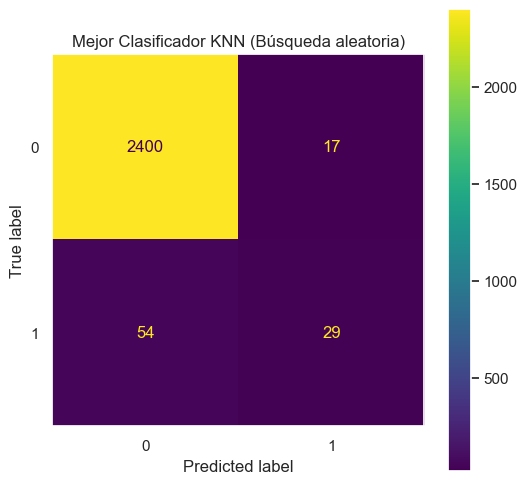

In [11]:
#Evaluamos
y_pred  = best_knn_grid_random.predict(X_test)

cm_best_knn_grid_random = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_grid_random,
                              display_labels=best_knn_grid_random.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Búsqueda aleatoria)");

In [12]:
# Midamos varias métricas:
print("Mejor Clasificador KNN (Búsqueda aleatoria)")
P = np.sum(cm_best_knn_grid_random[1, :])
N = np.sum(cm_best_knn_grid_random[0, :])
TP = cm_best_knn_grid_random[1, 1]
TN = cm_best_knn_grid_random[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Mejor Clasificador KNN (Búsqueda aleatoria)
Sensibilidad: 0.3493975903614458
Especificidad: 0.9929664873810509
Exactitud balanceada: 0.6711820388712484
Precision: 0.6304347826086957
Recuperación: 0.3493975903614458
F1-score: 0.4496124031007752


Ambos enfoques tienen sus ventajas y desventajas, y la elección entre ellos dependerá del tamaño del espacio de hiperparámetros, los recursos computacionales disponibles y la naturaleza del problema de machine learning que se está abordando.

## Implementación de algortimo genético

Hagamos un ejemplo de implementación de algortimo genético para la búsqueda de hiperparámetros. Para ello, se programo unas funciones para este problema, el cual se deja para consultar el detalle de la implementación:

In [13]:
import hyper_genalg as gen_lib

classifier_knn = KNeighborsClassifier

hyperparams = {"n_neighbors": np.arange(1, 100),    # Cantidad de vecinos.
               "weights": ["uniform", "distance"],  # Como se pesa los votos
               "p": np.arange(1.0, 100.0)}          # Valores para la distancia de Minkowski

# Creamos un maétodo de busqueda por grilla:
best_params, best_cost = gen_lib.genetic_hyper(classifier_knn, X_train, y_train, hyperparams, cv=3, scoring='f1',
                                               max_iterations=15, number_initial_population=300, initial_temperature=10,
                                               cooling_rate=0.95, n_jobs=-1)

En generación 0, la mejor metrica f1 es 0.3839181286549708, y los parametros son {'n_neighbors': 18, 'weights': 'distance', 'p': 43.0}
En generación 0, la mejor metrica f1 es 0.3846368056894372, y los parametros son {'n_neighbors': 5, 'weights': 'uniform', 'p': 54.0}
En generación 0, la mejor metrica f1 es 0.3862068965517242, y los parametros son {'n_neighbors': 17, 'weights': 'uniform', 'p': 59.0}
En generación 0, la mejor metrica f1 es 0.38797078696394555, y los parametros son {'n_neighbors': 16, 'weights': 'distance', 'p': 4.0}
En generación 0, la mejor metrica f1 es 0.39680723317086947, y los parametros son {'n_neighbors': 11, 'weights': 'uniform', 'p': 73.0}
En generación 0, la mejor metrica f1 es 0.40493337696885584, y los parametros son {'n_neighbors': 10, 'weights': 'distance', 'p': 51.0}
En generación 2, la mejor metrica f1 es 0.40603530534351145, y los parametros son {'n_neighbors': 10, 'weights': 'distance', 'p': 62.0}


In [14]:
best_knn_alg_gen = KNeighborsClassifier(**best_params)
best_knn_alg_gen.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=62.0, weights='distance')

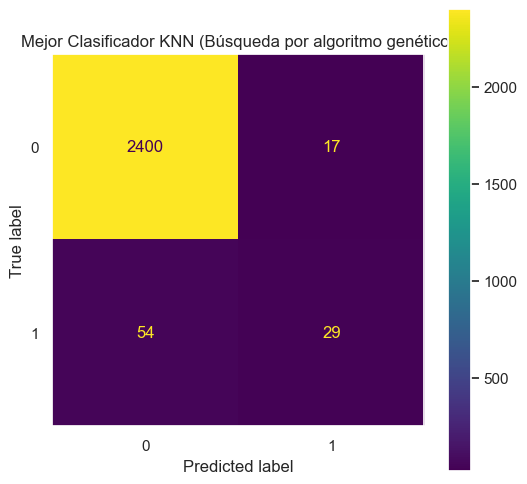

In [15]:
#Evaluamos
y_pred  = best_knn_alg_gen.predict(X_test)

cm_best_knn_alg_gen = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_alg_gen,
                              display_labels=best_knn_alg_gen.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Búsqueda por algoritmo genético)");

In [16]:
# Midamos varias métricas:
print("Mejor Clasificador KNN (Búsqueda por algoritmo genético)")
P = np.sum(cm_best_knn_alg_gen[1, :])
N = np.sum(cm_best_knn_alg_gen[0, :])
TP = cm_best_knn_alg_gen[1, 1]
TN = cm_best_knn_alg_gen[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Mejor Clasificador KNN (Búsqueda por algoritmo genético)
Sensibilidad: 0.3493975903614458
Especificidad: 0.9929664873810509
Exactitud balanceada: 0.6711820388712484
Precision: 0.6304347826086957
Recuperación: 0.3493975903614458
F1-score: 0.4496124031007752


## Usando Optuna

Por último, vamos a hacer una búsqueda de hiper-parámetros usando a Optuna. Como vimos en clase, Optuna es un framework que nos permite 
realizar búsqueda de hiper-parámetros de forma mas eficiente, y pensado tanto para funcionar de local con nuestra PC en una notebook, como ser ejecutado en clusters o en la nube.

Creemos la función que nos va a permitir evaluar las diferentes combinaciones de hiper-parámetros en Optuna:

In [17]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_float("p", 1.0, 100.0)
    
    classifier_knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    
    # Realizamos la validación cruzada
    score = cross_val_score(classifier_knn, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    return score.mean()

In [18]:
def champion_callback(study, frozen_trial):
    """
    Mostramos menos información, sino es demasiado verboso
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [19]:
# Creamos un estudio de Optuna
# Optuna es un poco verboso, dejamos que solo nos muestre logs de errores
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5000, callbacks=[champion_callback])

Initial trial 0 achieved value: 0.3835105620095478
Trial 17 achieved value: 0.38710027646967765 with  0.9273% improvement
Trial 20 achieved value: 0.40603530534351145 with  4.6634% improvement


In [20]:
# Obtenemos los mejores hiperparámetros encontrados
best_params = study.best_params
best_params

{'n_neighbors': 10, 'weights': 'distance', 'p': 99.69766108909147}

In [21]:
# Creamos el clasificador KNeighborsClassifier con los mejores hiperparámetros
classifier_knn_optuna = KNeighborsClassifier(**best_params)
# Entrenamos el clasificador con los datos de entrenamiento
classifier_knn_optuna.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=99.69766108909147, weights='distance')

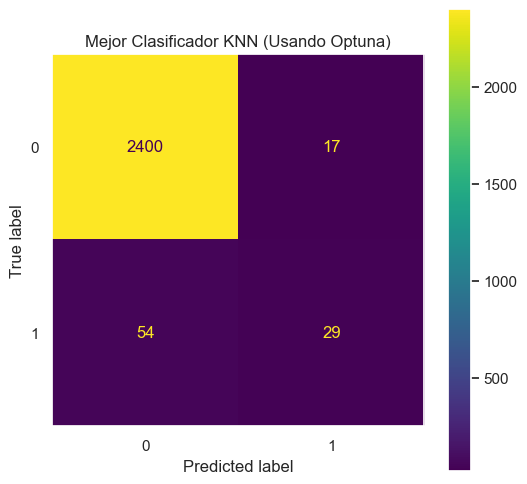

In [22]:
#Evaluamos
y_pred  = classifier_knn_optuna.predict(X_test)

cm_best_knn_optuna = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_optuna,
                              display_labels=classifier_knn_optuna.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Usando Optuna)");

In [23]:
# Midamos varias métricas:
print("Mejor Clasificador KNN (Usando Optuna)")
P = np.sum(cm_best_knn_optuna[1, :])
N = np.sum(cm_best_knn_optuna[0, :])
TP = cm_best_knn_optuna[1, 1]
TN = cm_best_knn_optuna[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especifixcidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Mejor Clasificador KNN (Usando Optuna)
Sensibilidad: 0.3493975903614458
Especifixcidad: 0.9929664873810509
Exactitud balanceada: 0.6711820388712484
Precision: 0.6304347826086957
Recuperación: 0.3493975903614458
F1-score: 0.4496124031007752


Este resultado puede variar con cada ejecución. Para este modelo en particular, dado los pocos hiper-parámetros, es mejor usar la búsqueda por grilla
directamente, pero en modelos más grandes (Deep Learning, o en ensambles), el rol de aplicar Optuna toma más importancia. Principalmente porque lo 
podemos llevar a clusters o a la nube para hacer búsquedas más poderosas.